<a href="https://colab.research.google.com/github/rikvik2006/Bread-next-dashboard-API/blob/master/AI_Chess_BOT_instanza_Riccardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCI vs SAN
- UCI: Universal Chess Interface è un protocollo che serve per comunicare tra un motore scacchistico e la sua interfaccia

Esempio:
## e2e4
La notazione UCI non indica il tipo del pezzo ma indica che qualunque pezzo nella casella specificata nei primi 2 caratteri si sposta nella casella specificata negli utimi 2

- SAN: Standart Algebraic Notation è una notazione più coplicata e ci sono diverse regole e caratteri che servono per specificare ad esempio il tipo del pezzo l'ho spostamento, se il pezzo mette in scacco

Esempio:
## Nf3
In questo caso la notazione indica che stiamo spostando il cavallo N (Knight) sulla casella f3
Una domanda spontanea e come facciamo a capoire quale cavallo dei 2 si deve spostare su quella casella? La risposta è che solo un cavallo può spostarsi su quella casella, e per ogni casella in quella sezione di tempo possono essere asociati per ogni tipo di pezzo uno a nessuno movimento, quindi anche se non specifichiamo esettamente quele pzzo dobbiamo muovere ma specifichiamo solo il tipo sapremo sempre quale si dova muovere perché solo un pezzo tra i tipi che abbiamo scelto potra fare quella determinata mossa.

#Installation of all the dependencies

In [1]:
!pwd
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

/content


In [2]:
!kaggle datasets download arevel/chess-games
!unzip -qq /content/chess-games.zip

 99% 1.43G/1.45G [00:17<00:00, 34.2MB/s]
100% 1.45G/1.45G [00:17<00:00, 87.9MB/s]


In [3]:
!pip install chess -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00


#CODE

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from pandas.core.generic import gc
import chess
import re

##Mapping the chess board

1. Map the chess board

In [5]:
letter_to_num = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
num_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}

##Chess board to matrix

###Board to rappresentation
This function create a numpy tensor (3D numpyarray) which rapresent the board containing every position of every chess pice.
Every chess pice has is own mapping (Is a matrix representing the chessboard that maps the position of only one type of pieces)

Questa funzione crea un numpy tensor (3D numpyarray) che reppresenta la scacchiera contenente la posizione di ogni scacco.
Ogni scacco a la sua posizione (è una matrice che rappresenta la scacchiera che mappa la poszione solo di un tipo di scacco)

In [6]:
def board_to_rep(board: chess.Board()):
  pieces = ['p', 'r', 'n', 'b', 'q', 'k'] #Initials of the names of the pieces / Inizializiamo i nomi dei pezzi
  # p (pown/pedone), r (rock/torre), n (knight/cavallo), b (bishop/alfiere), q (queen/regina), k (king/re)
  layers = []
  for piece in pieces:
    layers.append(layer_to_rep(board, piece))
  board_rep = np.stack(layers) # Essendoci soltanto una lista, la fuanzione stack non esegue uno stack delle liste, ma converte la lista in un array numpy (dato che la lista contiene delle matrici la lista diventa un tensore)
  return board_rep

###Layer rappresentation

Con layer si indica una scacchiera ma sulla quale sono solo presenti un tipo di pezzo, esempio solo i cavalli (biachi e neri)

In [7]:
def layer_to_rep(board, piece):
  str_board = str(board)

  """
  r n b q k b n r
  p p p p p p p p
  . . . . . . . .
  . . . . . . . .
  . . . . . . . .
  . . . . . . . .
  P P P P P P P P
  R N B Q K B N R
  """

  str_board = re.sub(f"[^{piece}{piece.upper()} \n]", ".", str_board)  # RegEx che seleziona tutto tranne la lettera del pezzo e la lettera maiuscola (pezzo bianco e nero), gli spazi e gli \n (brake line) e sostituisce le selezioni con un punto
  str_board = re.sub(f"{piece}", "1", str_board)
  str_board = re.sub(f"{piece.upper()}", "-1", str_board)
  str_board = re.sub("\.", "0", str_board)

  board_matrix = []
  for row in str_board.split("\n"):
    row = row.split()
    row = [int(x) for x in row]
    board_matrix.append(row)

  return np.array(board_matrix)

##Chess move to matrix

###Move to rappresentation

In [8]:
def move_to_rep(move, board: chess.Board()):
  board.push_san(move).uci()
  move = str(board.pop())

  print(move)

  from_output_layer = np.zeros((8, 8))
  from_row = 8 - int(move[1])
  from_column = letter_to_num[move[0]]
  from_output_layer[from_row][from_column] = 1

  to_output_layer = np.zeros((8, 8))
  to_row = 8 - int(move[3])
  to_column = letter_to_num[move[2]]
  to_output_layer[to_row][to_column] = 1

  return np.stack((from_output_layer, to_output_layer))

##Create move list from dataset move list


In [9]:
def create_move_list(string_move_list):
    return re.sub("\d*\. ", '', string_move_list).split()[:-1]

#Importing and filtering the data

In [10]:
chess_data_raw = pd.read_csv("/content/chess_games.csv", usecols=["AN", "WhiteElo", "BlackElo"])

In [11]:
chess_data = chess_data_raw[(chess_data_raw["WhiteElo"] >= 1900) & (chess_data_raw["BlackElo"] >= 1900)]
del chess_data_raw
gc.collect()
chess_data = chess_data[["AN"]]
chess_data = chess_data[~chess_data["AN"].str.contains("{")]
chess_data = chess_data[chess_data["AN"].str.len() > 20]
print(chess_data.shape)

(1017420, 1)


In [12]:
chess_data.head()

,AN
4,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
7,1. d4 d5 2. Nf3 Nf6 3. Bf4 c6 4. e3 Bg4 5. Be2...
8,1. d4 Nf6 2. Bf4 e6 3. e3 d5 4. Nf3 h6 5. Bd3 ...
13,1. b4 e6 2. Bb2 d5 3. Nf3 Nf6 4. b5 Be7 5. e3 ...
16,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...


#Creating the Dataset
In PyTorch, la classe Dataset è utilizzata per gestire e organizzare i dati che verranno utilizzati per l'addestramento e la validazione dei modelli di apprendimento automatico. Questi dati possono essere immagini, testo, suoni o qualsiasi altro tipo di informazione. La classe Dataset fornisce un'interfaccia comoda per accedere a questi dati in modo efficiente.

Il metodo __getitem__ è un metodo speciale nella classe Dataset che ti permette di accedere a un singolo campione di dati in base al suo indice. Quando crei una sottoclasse della classe Dataset e implementi il metodo __getitem__, stai fondamentalmente definendo come ottenere un campione specifico dai dati. Ad esempio, se stai lavorando con un set di immagini, __getitem__ potrebbe caricare un'immagine dal disco e applicare le trasformazioni necessarie.

In [13]:
class ChessDataset(Dataset):

    def __init__(self, games):
        super().__init__()
        self.games = games

    def __len__(self):                                          #len(self) return call __len__
        return self.games.shape[0]

    def __getitem__(self, index):
        game_index = np.random.randint(self.games.shape[0])     #Create the index for get the game
        random_game_moves = self.games['AN'].values[game_index] #Get the game using the game_index
        moves = create_move_list(random_game_moves)             #Create the move list using the create_move_list function
        move_index = np.random.randint(len(moves) - 1)          #Create the index for get the move
        next_move = moves[move_index]                           #Get the move
        moves = moves[:move_index]                              #I don't know why this
        board = chess.Board()                                   #Create the board object

        for move in moves:
            board.push_san(move)

        board_rep = board_to_rep(board)                         # Trasformiamo la board in una reppresetazione. La scacchiera viene trasformata
                                                                # in una matrice di zero e di uno ma solo per un tipo di pezzo, quindi ogni matrice
                                                                # con un tipo di pezzo viene aggiunta ad un np array creando cosi un tensore

        move_rep = move_to_rep(next_move, board)                # Trasforma la mossa in una rappresetazione che comprende 2 matrici di zero e di uno
                                                                # che contengono tutti zerro tranne la posizione del pezzo che sta per veire spostato
                                                                # sotto forma di un uno e la matrice che contine la poszione del pezzo spostato
                                                                # rappresetato come un uno. Queste matrici vengono unite in un np array quindi crendo
                                                                # un tensore

        if move_index % 2 == 1:
          board_rep *= -1

        return board_rep, move_rep


In [30]:
data_train = ChessDataset(chess_data["AN"])
print(chess_data["AN"])
print(data_train)
data_train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True, drop_last=True)

4          1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
7          1. d4 d5 2. Nf3 Nf6 3. Bf4 c6 4. e3 Bg4 5. Be2...
8          1. d4 Nf6 2. Bf4 e6 3. e3 d5 4. Nf3 h6 5. Bd3 ...
13         1. b4 e6 2. Bb2 d5 3. Nf3 Nf6 4. b5 Be7 5. e3 ...
16         1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...
                                 ...                        
6256155    1. e4 d5 2. Nc3 d4 3. Nce2 c5 4. d3 Nc6 5. f4 ...
6256158    1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 h6 5. g3 B...
6256160    1. e4 e5 2. Nc3 Nc6 3. Nf3 Nf6 4. d4 exd4 5. N...
6256161    1. d4 Nf6 2. c4 g6 3. Nc3 d5 4. Nf3 Bg7 5. Qb3...
6256183    1. e4 e6 2. d4 d6 3. Nc3 c6 4. Nf3 Be7 5. Bc4 ...
Name: AN, Length: 1017420, dtype: object


In [15]:
board = chess.Board()

print(board)
print("\n")
print(board_to_rep(board))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


[[[ 0  0  0  0  0  0  0  0]
  [ 1  1  1  1  1  1  1  1]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [-1 -1 -1 -1 -1 -1 -1 -1]
  [ 0  0  0  0  0  0  0  0]]

 [[ 1  0  0  0  0  0  0  1]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [-1  0  0  0  0  0  0 -1]]

 [[ 0  1  0  0  0  0  1  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0 -1  0  0  0  0 -1  0]]

 [[ 0  0  1  0  0  1  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0 

## Costruiamo la CNN

In [16]:
class module(nn.Module):
  """Base module for the neural network"""
  def __init__(self, hidden_size):
    super().__init__()
    self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
    self.batch_nomalization1 = nn.BatchNorm2d(hidden_size)
    self.batch_nomalization2 = nn.BatchNorm2d(hidden_size)
    self.activation1 = nn.SELU()
    self.activation2 = nn.SELU()

  def forward(self, x):
    """This method pass the data into the network module"""

    #Using a residual connection https://paperswithcode.com/method/residual-connection
    x_input = torch.clone(x)
    x = self.conv1(x)
    x = self.batch_nomalization1(x)
    x = self.activation1(x)
    x = self.conv2(x)
    x = self.batch_nomalization2(x)
    x = self.activation2(x)

    return x

Questo modulo serve come una parte ripetibile della network percedente

In [17]:
class ChessNet(nn.Module):
  def __init__(self, hidden_layers=4, hidden_size=200):
    super().__init__()
    self.hidden_layers = hidden_layers
    self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
    self.module_list = nn.ModuleList([module(hidden_size) for i in range(hidden_layers)])
    self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

  def forward(self, x):   # x = board rappresentation
    x = self.input_layer(x);
    x = F.relu(x)

    for i in range(self.hidden_layers):
      x = self.module_list[i](x)

    x = self.output_layer(x)

    return x

In [18]:
# metric_from = nn.CrossEntropyLoss()
# metric_to = nn.CrossEntropyLoss()

In [19]:
# loss_from = metric_from(output[:,0,:], y[:,0,:])
# loss_to = metric_to(output[:,1,:], y[:,1,:])
# loss = loss_from + loss_to

### Funzioni Helper per rendere l'AI più forte

Creiamo una funzione che controlla tutte le mosse disponibili sulla scacchiera, e le gioca tutte cerando una mossa che faccia scacco matto. Se la trova la restiuisce altmenti ritorna alla situazione iniziale.

In [20]:
def check_mate_single(board: chess.Board):
  board = board.copy()
  legal_moves = list(board.legal_moves)
  for move in legal_moves:
    board.push_uci(str(move))
    if board.is_checkmate:
      move = board.pop()
      return move
    _ = board.pop()

Creaiamo una funzione che dati una lista di nuemri li converte in una distribuzione di probabilità
https://en.wikipedia.org/wiki/Softmax_function

Questo ci permette di creare una distrubizione di probabilità utilizzando la fuznione softmax. Dopo eleviamo la nostra disttribizione alla terza in modo tale da distanziare le probabilità tra loro. Questo permette alla AI di scegliere spesso una tra le migliori mosse ma lasciando comunque un pò di radomicità. Altrimenti giocando contro se stesso farebbe sempre le stesse mosse.

In [21]:
def distribution_over_moves(vals):
  # Soft max function
  probs = np.arrayy(vals)
  probs = np.exp(probs)
  probs = probs / probs.sum()            # Normaliziamo i valori
  # Eleviamo la distribuzione di probabilità alla terza e rinormaliziamo i valori
  # Questo ci permette di distanziare le probabilità e quindi fare in modo che AI scela una tra le migliori mosse, ma comunque lasciandoli
  # abbastanza randomicità
  probs = probs ** 3
  probs = probs / probs.sum()            # Normaliziamo i valori
  return probs

### Funzione per la scleta delle mosse

In [22]:
def choose_move(board: chess.Board, player, color):
  legal_moves = list(board.legal_moves)

  # Se è trova un possiblie scacco matto tra le mosse disponibili sceglie quella mossa
  move = check_mate_single(board)
  if move is not None:
    return move

  # Trasformiamo la rappresetazione della scacchiera in un torch.Tensor e convertiamo in float e l'ho predisponiamo per l'eseguzione
  # tramite cuda core ovvero core all interno della nostra scheda video specializati nei calcoli tra tensori
  x = torch.Tensor(board_to_rep(board)).float().to("cuda")
  if color == chess.BLACK:
    x *= -1
  # Transfromiamo il tensore in un tensore ad una dimensione
  x = x.unsqueeze(0)
  # move = predict(x)
  move = ChessNet(x)

  vals = []
  # Creiamo un array nel quale inseiamo tutte le posizioni iniziali di una mossa, es e2e4 prendiamo e2
  froms = [str(legal_move)[:2] for legal_move in legal_moves]
  # Trasformiamo la lista in un set in modo tale da redere gli elementi al interno unici e poi ri convertiamola di nuovo in una lista
  froms = list(set(froms))

  for from_ in froms:
    val = move[0,:,:][8 - int(from_[1]),letter_to_num[from_[0]]]
    vals.append(val)

  # I valori sono convertiti in una distrubuzione di probabilità
  probs = distribution_over_moves(vals)

  # Quindi ora segliamo il pezzo che con più probabilità è il miglore da muovere (per ora stiamo scegliando solo il pezzo non ancora la mossa da fare)
  choosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

  vals = []
  for legal_move in legal_moves:
    from_ = str(legal_move)[:2]                                     # Posizione iniziale del pezzo
    if from_ == choosen_from:                                       # Se tra le mosse legali troviamo la posizione pre mossa scelta allora
                                                                    # allora prediamo la mossa che esegue e aggiungiamola al array dei valori
      to = str(legal_move)[2:]
      val = move[1,:,:][8 - int(to[1]),letter_to_num[to[0]]]
      vals.append(val)                                              # Questo ci permette di scelgliere tra tutte le mosse dispodibili dalla casella
                                                                    # che abbiamo scelto
    else:
      vals.append(0)

  # np.argmax restituisce l'indice dal valore più altro della matrice appiattita.
  # con questo sceglaimo la mossa che a più probabilità
  choosen_move = legal_moves[np.argmax(vals)]
  return choosen_move

## Alleniamo la network
Cosa è l'entropia incrociata: https://it.wikipedia.org/wiki/Entropia_incrociata

In [29]:
# Crea un'istanza della rete neurale
net = ChessNet()


criterion = nn.CrossEntropyLoss()  # Puoi usare la stessa loss che hai usato nella tua implementazione
# Definisci funzione di perdita e ottimizzatore
metric_from = nn.CrossEntropyLoss()               # Definiamo i criteri di perdità dell entropia
metric_to = nn.CrossEntropyLoss()

# Definiamo l'optimizer con l'earning rage di 0.001, qusto permetterà di modificare i parametri della rete
# accuratamente, anche se ci costera più tempo per l'allenamento
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Imposta il dispositivo (GPU se disponibile)
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

# Addestramento del modello
num_epochs = 10  # Numero di epoche di addestramento
for epoch in range(num_epochs):
    net.train()  # Imposta il modello in modalità di addestramento
    total_loss = 0.0

    try:
      for batch_idx, (board_rep, move_rep) in enumerate(data_train_loader):
          board_rep, move_rep = board_rep.to(device), move_rep.to(device)

          # Pulisci il gradiente
          optimizer.zero_grad()

          # Esegui l'inoltro (forward pass)
          output = net(board_rep)

          # Calcola la loss
          # loss = criterion(output, move_rep)
          loss_from = metric_from(output[:,0,:], move_rep[:,0,:])
          loss_to = metric_to(output[:,1,:], move_rep[:,1,:])
          loss = loss_from + loss_to

          # Esegui la retropropagazione (backward pass) e aggiorna i pesi
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")
    except KeyError as err:
      print("🟥 KeyError", err)

print("Addestramento completato!")

🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
🟥 KeyError 'AN'
Addestramento completato!


# IMPORTANTISSIMO: Salvare i parametri della rete dopo avera addestrata per evitare di ri addestrala
Savando i parametri possiamo evitare di addestrare dinuovo la rete ogni volta che vogliamo utilizzarla.

In [24]:
# Salva i pesi del modello in un file (cwd: /content)
torch.save(net.state_dict(), 'chess_model_weights.pth')
print("Pesi del modello salvati.")

# Carica i pesi del modello da un file
net.load_state_dict(torch.load('chess_model_weights.pth'))
print("Pesi del modello caricati.")

# Imposta il dispositivo (GPU se disponibile)
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

Pesi del modello salvati.
Pesi del modello caricati.


ChessNet(
  (input_layer): Conv2d(6, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_list): ModuleList(
    (0-3): 4 x module(
      (conv1): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_nomalization1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_nomalization2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): SELU()
      (activation2): SELU()
    )
  )
  (output_layer): Conv2d(200, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

e2e4
[[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]]]


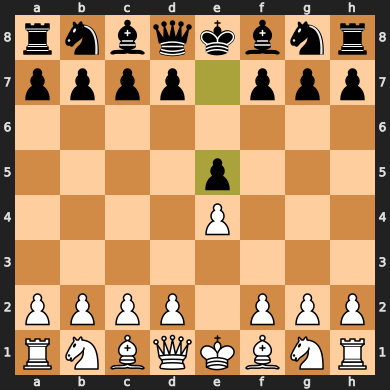

In [25]:
board = chess.Board()
move_rep = move_to_rep("e4", board)
print(move_rep)
board
board.push_san("e4")
board
board.push_san("e5")
board